In [1]:
import os
import sys
import glob
import code
import json
import scipy
import difflib
import datetime
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy import stats
from statsmodels import robust
from shapely.ops import unary_union
from scipy.stats.mstats import winsorize

In [ ]:
def process_EIA(input_dir):
    #
    states = []
    usa = []
    for year in np.arange(2017,2022): # data is available from 2016-22 but we are only interested in 2017-21
        # print("Processing year: {}".format(year), flush=True)
        df = pd.read_excel(os.path.join(input_dir, "Reliability_{}.xlsx".format(year)))
        # df = df.iloc[:,0:16]
        df = df.drop(df.index[-1])
        # dataset's format got updated in 2021
        if year != 2021:
            df.columns = df.iloc[0]
            df = df.drop(df.index[0])
            if year == 2019: # Only 2019 data has an extra column called "Short Form". We remove it for consistency.
                df = df.drop(columns=["Short Form"])
            df.columns = ['year', 'utility_number', 'utility_name', 'state', '_', 'saidi_w_med_ieee', '_', '_','saidi_wo_med_ieee', '_', '_','_', '_', '_', 'customers_ieee', '_', '_', 'saidi_w_med_other', '_', '_', 'saidi_wo_med_other', '_', '_', 'customers_other', '_', '_', '_', '_']            
            df = df.drop(columns=["_"])
        else:
            df.columns = df.iloc[1]
            df = df.drop(df.index[[0,1]])
            df.columns = ['year', 'utility_number', 'utility_name', 'state', '_','saidi_w_med_ieee', '_', '_', 'saidi_wo_med_ieee', '_', '_', '_', '_', '_', 'customers_ieee', '_', '_', 'saidi_w_med_other', '_', '_', 'saidi_wo_med_other', '_', '_', 'customers_other', '_', '_', '_', '_']
            df = df.drop(columns=["_"])
        # replace "." with nans
        for col in ["saidi_w_med_ieee","saidi_wo_med_ieee","customers_ieee", "saidi_w_med_other","saidi_wo_med_other","customers_other"]:
            df[col] = df[col].apply(lambda x: x if (isinstance(x, float)==True) | (isinstance(x, int)==True) else np.nan)

        # fill nans in IEEE standard columns with values from the other standard columns (if available)
        df.loc[:,"saidi_w_med_ieee"] = df["saidi_w_med_ieee"].fillna(df["saidi_w_med_other"])
        df.loc[:,"saidi_wo_med_ieee"] = df["saidi_wo_med_ieee"].fillna(df["saidi_wo_med_other"])
        df.loc[:,"customers_ieee"] = df["customers_ieee"].fillna(df["customers_other"])

        # remove all the other standard columns
        df = df.drop(columns = ["saidi_w_med_other", "saidi_wo_med_other", "customers_other"])

        # rename IEEE columns
        df = df.rename(columns={"saidi_w_med_ieee":"saidi_w_med", "saidi_wo_med_ieee":"saidi_wo_med", "customers_ieee":"customers"})

        # compute outage duration 
        df["customer_outage_hours_w_med"] = df["saidi_w_med"].mul(df["customers"])/60
        df["customer_outage_hours_wo_med"] = df["saidi_wo_med"].mul(df["customers"])/60
        df["customer_outage_hours_only_med"] = df["customer_outage_hours_w_med"] - df["customer_outage_hours_wo_med"]

        """
        state-level
        """
        # total outage duration and total customers in state
        df = df.groupby(["state","year"])[["customer_outage_hours_w_med","customer_outage_hours_wo_med","customer_outage_hours_only_med","customers"]].sum().reset_index()
        # calculate saidi - storm and no storm
        df.loc[:,"saidi_w_med"] = df["customer_outage_hours_w_med"].div(df["customers"]) # overall SAIDI
        df.loc[:,"saidi_wo_med"] = df["customer_outage_hours_wo_med"].div(df["customers"]) # SAIDI without major events
        df.loc[:,"saidi_only_med"] = df["customer_outage_hours_only_med"].div(df["customers"]) # SAIDI only major events
        #
        states.append(df)

        """
        USA-level
        """
        # total outage duration and total customers in state
        c = df.groupby(["year"])[["customer_outage_hours_w_med","customer_outage_hours_wo_med","customer_outage_hours_only_med","customers"]].sum().reset_index()
        # calculate saidi - storm and no storm
        c.loc[:,"saidi_w_med"] = c["customer_outage_hours_w_med"].div(c["customers"]) # overall SAIDI
        c.loc[:,"saidi_wo_med"] = c["customer_outage_hours_wo_med"].div(c["customers"]) # SAIDI without major events
        c.loc[:,"saidi_only_med"] = c["customer_outage_hours_only_med"].div(c["customers"]) # SAIDI only major events
        #
        usa.append(c)
    #
    states = pd.concat(states).reset_index(drop=True)
    usa = pd.concat(usa).reset_index(drop=True)
    return states, usa

In [ ]:
def process_statenames(usa_statenames):
    sn = pd.read_csv(os.path.join(usa_statenames, "data.csv"))
    sn.loc[:,"StateName"] = sn["state"].str.replace(r'[^A-Za-z]+', '', regex=True).str.lower()
    sn = sn.rename(columns={"code":"StateName_short"})
    sn = sn[["StateName","StateName_short"]].drop_duplicates()
    return sn

In [ ]:
pous_data_dir = "/POUS"
#-----unity
stormdata_dir = "/USA_storms_data"
counties_shapefile = "cb_2018_us_county_500k.shp"
eia_data_dir = "/EIA_reliability_2016_2021"
usa_statenames = "/USA_states_fullname_to_shortname"

In [ ]:
name2fips = pd.read_pickle(os.path.join(pous_data_dir, "state_county_city_utility.pkl")) #maps countyname to fips
print("name2fips loaded @ {}".format(datetime.datetime.now()), flush=True)

In [ ]:
# load yearly POUS values for county, state and country
agg_pous_data_dir = "/POUS_and_storms"
file_version = 2

county_pous = pd.read_csv(os.path.join(agg_pous_data_dir, "yearly_county_saidi_v{}.csv".format(file_version)))
state_pous = pd.read_csv(os.path.join(agg_pous_data_dir, "yearly_state_saidi_v{}.csv".format(file_version)))
country_pous = pd.read_csv(os.path.join(agg_pous_data_dir, "yearly_country_saidi_v{}.csv".format(file_version)))

In [ ]:
state_eia, country_eia = process_EIA(input_dir=eia_data_dir)

# SAIDI (POUS vs. EIA) country-year plot (not in paper)

In [ ]:
"""
Country level plots
"""
from scipy import stats

c2 = country_pous[["year","saidi","saidi_no_storm","saidi_only_storm"]].rename(columns={"saidi":"saidi_pous","saidi_no_storm":"saidi_no_storm_pous","saidi_only_storm":"saidi_storm_pous"})
usa2 = country_eia[["year","saidi_w_med","saidi_wo_med","saidi_only_med"]].rename(columns={"saidi_w_med":"saidi_eia","saidi_wo_med":"saidi_no_storm_eia","saidi_only_med":"saidi_storm_eia"})

dm = pd.merge(c2, usa2, on=["year"], how="left")
dm = dm.dropna()

x = dm["saidi_eia"].values
y = dm["saidi_pous"].values
n = dm["year"].values

x_storm = dm["saidi_storm_eia"].values
y_storm = dm["saidi_storm_pous"].values

x_no_storm = dm["saidi_no_storm_eia"].values
y_no_storm = dm["saidi_no_storm_pous"].values

slope, intercept, r, _, _ = stats.linregress(x, y)
slope_storm, intercept_storm, r_storm, _, _ = stats.linregress(x_storm, y_storm)
slope_no_storm, intercept_no_storm, r_no_storm, _, _ = stats.linregress(x_no_storm, y_no_storm)

fs = 16
fig, ax = plt.subplots(figsize=(11,10))
ax.scatter(x, y, c="r", marker="*", label="Overall SAIDI")
ax.scatter(x_storm, y_storm, c="b", marker="^", label="SAIDI only storm event days")
ax.scatter(x_no_storm, y_no_storm, c="k", marker="s", label="SAIDI excluding storm event days")

ax.plot(np.arange(1,15), slope*np.arange(1,15) + intercept, c="r")
ax.plot(np.arange(1,15), slope_storm*np.arange(1,15) + intercept_storm, c="b")
ax.plot(np.arange(1,15), slope_no_storm*np.arange(1,15) + intercept_no_storm, c="k")

ax.plot(np.arange(1,15), np.arange(1,15), linestyle="dashdot")
ax.set_xlim([1,14])
ax.set_ylim([1,14])

for i, txt in enumerate(n):
    ax.annotate(txt, (x[i]+0.1, y[i]+0.1), fontsize=fs)
    ax.annotate(txt, (x_storm[i]+0.1, y_storm[i]+0.1), fontsize=fs)
    ax.annotate(txt, (x_no_storm[i]+0.1, y_no_storm[i]+0.1), fontsize=fs)

ax.set_xlabel("SAIDI - EIA", fontsize=fs)
ax.set_ylabel("SAIDI - POUS", fontsize=fs)
ax.tick_params(axis='both', which='major', labelsize=fs)

plt.legend(fontsize=fs)
plt.grid()
plt.tight_layout()
plt.savefig("country_level_SAIDI_scatterplot.pdf", bbox_inches="tight")
plt.show()

# State SAIDI scatter (not in paper)

In [ ]:
"""
State level plots
"""
from scipy import stats

c2 = state_pous[["StateName","year","saidi","saidi_no_storm","saidi_only_storm"]].rename(columns={"saidi":"saidi_pous","saidi_no_storm":"saidi_no_storm_pous","saidi_only_storm":"saidi_storm_pous"})
usa2 = state_eia[["state","year","saidi_w_med","saidi_wo_med","saidi_only_med"]].rename(columns={"state":"StateName_short","saidi_w_med":"saidi_eia","saidi_wo_med":"saidi_no_storm_eia","saidi_only_med":"saidi_storm_eia"})


sn = process_statenames(usa_statenames=usa_statenames)
c2 = pd.merge(c2, sn, on=["StateName"], how="left")

#
dm = pd.merge(c2, usa2, on=["StateName_short","year"], how="left")
dm = dm.dropna()

#
fs = 14
nrows = 5
ncols = 1
i = 0
j = 0
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(10,40))

grouped = dm.groupby(["year"])

for _, dg in grouped:
    year = dg["year"].unique()[0]
    #
    x = dg["saidi_eia"].values
    y = dg["saidi_pous"].values
    n = dg["StateName_short"].values
    #
    ax[i].scatter(x, y, c="r", marker="*")
    ax[i].set_title("Year:{}".format(year), fontsize=fs)
    # ax[i].set_xscale("log")
    # ax[i].set_yscale("log")
    # ax[i].set_xlim([1,100])
    # ax[i].set_ylim([1,100])
    #
    for k, txt in enumerate(n):
        ax[i].annotate(txt, (x[k]+0.1, y[k]+0.1), fontsize=fs)
    #
    ax[i].set_xlabel("SAIDI - EIA", fontsize=fs)
    ax[i].set_ylabel("SAIDI - POUS", fontsize=fs)
    ax[i].tick_params(axis='both', which='major', labelsize=fs)
    #
    i = i + 1

        
# plt.legend(fontsize=fs)
# plt.grid()
plt.tight_layout()
# plt.savefig("state_level_SAIDI_scatterplots.pdf", bbox_inches="tight")
plt.show()

# Utilities Summaries (not in paper)

In [ ]:
def total_utilities_covered(pous_data_dir, eia_data_dir):
    """
    Better if viewed in jupyter notebook

    Compares total number of utilities covered in EIA with POUS
    """
    #
    # EIA
    utils = []
    for year in np.arange(2016,2022):
        df = pd.read_excel(os.path.join(eia_data_dir, "Reliability_{}.xlsx".format(year)))
        df = df.iloc[:,0:16]
        df = df.drop(df.index[-1])
        # dataset's format got updated in 2021
        if year != 2021:
            df.columns = df.iloc[0]
            df = df.drop(df.index[0])
            df = df[["Data Year", "Utility Number", "Utility Name", "State", "SAIDI With MED", "SAIDI Without MED", "Number of Customers"]]
            df = df.rename(columns={"Data Year":"year", "Utility Number":"utility_number","Utility Name":"utility_name","State":"state","SAIDI With MED":"saidi_w_storm","SAIDI Without MED":"saidi_wo_storm","Number of Customers":"customers"})
        else:
            df.columns = df.iloc[1]
            df = df.drop(df.index[[0,1]])
            df.columns = ["year", "utility_number", "utility_name", "state", "_", "saidi_w_storm", "_", "_", "saidi_wo_storm", "_", "_", "_", "_", "_", "customers", "_"]
            df = df.drop(columns=["_"])
        #
        df = df[["year","state","utility_name"]].drop_duplicates()
        df.loc[:,"utility_name"] = df["utility_name"].str.replace(r'[^A-Za-z]+', '', regex=True).str.lower()
        df.loc[:,"state"] = df["state"].str.replace(r'[^A-Za-z]+', '', regex=True).str.lower()
        utils.append(df)
    utils = pd.concat(utils).reset_index(drop=True).rename(columns={"utility_name":"eia_utility"})
    #
    # POUS
    raw_filename = "POUS_Export_CountyByUtility_Daily_2017-2021.csv"
    dc = pd.read_csv(os.path.join(pous_data_dir, raw_filename), encoding='utf-16')
    dc.loc[:,"RecordDate"] = pd.to_datetime(dc.loc[:,"RecordDate"], format="%Y-%m-%d")
    dc.loc[:,"year"] = dc.loc[:,"RecordDate"].dt.year
    dc = dc[["year","StateName","UtilityName"]].drop_duplicates()                                                                             
    #
    dc.loc[:,"StateName"] = dc["StateName"].str.replace(r'[^A-Za-z]+', '', regex=True).str.lower()
    dc.loc[:,"UtilityName"] = dc["UtilityName"].str.replace(r'[^A-Za-z]+', '', regex=True).str.lower()
    dc = dc[["year","StateName","UtilityName"]].drop_duplicates().rename(columns={"UtilityName":"pous_utility"}) 
    #

    # Compare the two at country-year level 
    u1 = utils.groupby(["year"])[["eia_utility"]].nunique().reset_index()
    c1 = dc.groupby(["year"])[["pous_utility"]].nunique().reset_index()
    db1 = pd.merge(u1, c1, on=["year"])
    db1 = db1[(db1["year"].isin([2017,2018,2019,2020,2021]))]
    # plot
    n = db1["year"].values
    x = db1["eia_utility"].values
    y = db1["pous_utility"].values

    fs = 16
    fig, ax = plt.subplots(figsize=(7,6))
    ax.scatter(x, y, c="r", marker="*")
    ax.set_xlim([400,1200])
    ax.set_ylim([400,800])
    for i, txt in enumerate(n):
        ax.annotate(txt, (x[i]+0.12, y[i]+0.12), fontsize=fs)
    ax.set_xlabel("Total utilities covered - EIA", fontsize=fs)
    ax.set_ylabel("Total utilities covered - POUS", fontsize=fs)
    ax.tick_params(axis='both', which='major', labelsize=fs)

    plt.grid()
    plt.tight_layout()
    # plt.savefig("coverage_POUS_EIA_scatterplot.pdf", bbox_inches="tight")
    plt.show()

    return None

In [ ]:
total_utilities_covered(pous_data_dir, eia_data_dir)

# POUS vs. EIA, POUS coverage plots (PAPER)

In [ ]:
"""
DESCRIPTIVE STATS

POUS COVERAGE PLOTS
(February 7, 2023)
"""

def POUS_county_daily_outages(input_dir):
    """
    - performs basic processing of the CountyByUtility daily summary dataset
    - winsorizes customers tracked
    - aggregates customers out and tracked to county level
    - output: daily customers out and tracked in each county
    """
    raw_filename = "POUS_Export_CountyByUtility_Daily_2017-2021.csv"
    dm = pd.read_csv(os.path.join(input_dir, raw_filename), encoding='utf-16')
    dc = dm.copy() #create a backup
    dc.loc[:,"RecordDate"] = pd.to_datetime(dc.loc[:,"RecordDate"], format="%Y-%m-%d")
    dc.loc[:,"year"] = dc.loc[:,"RecordDate"].dt.year
    #
    dc.loc[:,"StateName"] = dc["StateName"].str.replace(r'[^A-Za-z]+', '', regex=True).str.lower()
    dc.loc[:,"UtilityName"] = dc["UtilityName"].str.replace(r'[^A-Za-z]+', '', regex=True).str.lower()
    dc.loc[:,"CountyName"] = dc["CountyName"].str.replace(r'[^A-Za-z]+', '', regex=True).str.lower()
    # add CountyFIPS
    dc = pd.merge(dc, name2fips[["StateName","CountyName","CountyFIPS"]].drop_duplicates(), on=["StateName","CountyName"], how="left")
    #
    ##### Total number of utilities, counties and states tracked
    utils = dc.groupby(["year"])[["UtilityName","CountyFIPS","StateName"]].nunique().reset_index()
    print("Total utilities, counties and states tracked by year")
    print(utils) 
    """
    calculate customers tracked
    - winsorize over a year
    - output: it only changes daily CT values when they are beyond the winsorization extremes
    """
    #
    def winsorize_series(group):
        return winsorize(group, limits=[0.1,0.2])
    # winsorize year by year
    dc.loc[:,"CustomersTracked_clean"] = dc.groupby(["StateName","CountyName","CountyFIPS","UtilityName","year"])["CustomersTracked"].transform(winsorize_series)
    """
    calculate daily SAIDI in each county
    """
    # add all customer outage-hours and customers tracked in a county
    dc = dc.groupby(["StateName","CountyName","CountyFIPS","RecordDate"])[["CustomersTracked_clean","CustomerHoursOutTotal"]].sum().reset_index()
    dc["SAIDI"] = dc["CustomerHoursOutTotal"].div(dc["CustomersTracked_clean"])
    ##### Total number of customers tracked
    pc = dc.copy()
    pc["year"] = pc["RecordDate"].dt.year
    pc = pc.groupby(["StateName","CountyName","year"])["CustomersTracked_clean"].median().reset_index()
    pc = pc.groupby(["year"])["CustomersTracked_clean"].sum().reset_index()
    print("Total customers tracked by year")
    return dc, utils, pc

dc, utils, pc = POUS_county_daily_outages(input_dir=pous_data_dir)


In [ ]:
# plot of coverage -- counties by year and customers tracked by year

# eliminate 2022 values
pc = pc[(pc["year"] != 2022)]
utils = utils[(utils["year"]!=2022)]

fs = 16
fig, ax1 = plt.subplots(figsize=(7.5,6))
#
l1 = ax1.plot(pc["year"], pc["CustomersTracked_clean"], c="r", marker="*", markersize=10, label="Customers tracked")
ax1.set_xlabel("Year", fontsize=fs)
ax1.set_ylabel("Customers tracked", fontsize=fs)
ax1.set_ylim([0.75e8,1.321e8])
ax1.tick_params(axis='both', labelsize=fs)
ax1.yaxis.offsetText.set_fontsize(fs+1)
#
ax2 = ax1.twinx()
l2 = ax2.plot(utils["year"], utils["CountyFIPS"], c="b", marker="^", markersize=10, label="Counties covered")
ax2.set_ylabel("Counties covered", fontsize=fs)
ax2.set_ylim([2500,3100])
ax2.tick_params(axis='both', labelsize=fs)
#
ls = l1+l2
labs = [l.get_label() for l in ls]
ax1.legend(ls, labs, loc="lower right", fontsize=fs)
plt.tight_layout()
# plt.savefig("coverage_summary.png", bbox_inches="tight")
plt.show()

In [ ]:
#### plot of country-wide SAIDI values (POUS)
ps= country_pous[(country_pous["year"]!=2022)]

fs = 16
fig, ax = plt.subplots(figsize=(8,6))
#
# plt.bar(ps["year"], ps["saidi_only_storm"], width=0.6, edgecolor='black', label="Weather-related", zorder=200)
# plt.bar(ps["year"], ps["saidi_no_storm"], bottom=ps["saidi_only_storm"], width=0.6, edgecolor='black', label="Non-weather-related", zorder=200)

plt.bar(ps["year"], ps["saidi_no_storm"], width=0.6, edgecolor='black', label="Non-weather-related", zorder=200)
plt.bar(ps["year"], ps["saidi_only_storm"], bottom=ps["saidi_no_storm"], width=0.6, edgecolor='black', label="Weather-related", zorder=200)
#
plt.xlabel("Year", fontsize=fs)
plt.ylabel("SAIDI calculated using POUS", fontsize=fs)
plt.tick_params(axis='both', labelsize=fs)
#
plt.legend(bbox_to_anchor=(0.5, 1.12), loc='upper center', ncol=2, fontsize=fs)
#
plt.grid(axis="y", zorder=0)
plt.tight_layout()
plt.savefig("pous_saidi_summary.png", bbox_inches="tight")
plt.show()

In [ ]:
#### plot of country-wide SAIDI values (EIA)

# eia_data_dir = "/gypsum/eguide/projects/zshah/data/EIA_reliability_2016_2021"
# _, country_eia = process_EIA(input_dir=eia_data_dir)

es= country_eia.copy()

fs = 16
fig, ax = plt.subplots(figsize=(8,6))
#
# plt.bar(es["year"], es["saidi_only_med"], width=0.6, edgecolor='black', label="Only major event days", zorder=200)
# plt.bar(es["year"], es["saidi_wo_med"], bottom=es["saidi_only_med"], width=0.6, edgecolor='black', label="Excluding major event days", zorder=200)

plt.bar(es["year"], es["saidi_wo_med"], width=0.6, edgecolor='black', color='#1D2F6F', label="Excluding major event days", zorder=200)
plt.bar(es["year"], es["saidi_only_med"], bottom=es["saidi_wo_med"], width=0.6, edgecolor='black', color='#8390FA', label="Only major event days", zorder=200)

#
plt.xlabel("Year", fontsize=fs)
plt.ylabel("EIA-reported SAIDI", fontsize=fs)
plt.tick_params(axis='both', labelsize=fs)
#
plt.legend(bbox_to_anchor=(0.5, 1.12), loc='upper center', ncol=2, fontsize=fs)
#
plt.grid(axis="y", zorder=0)
plt.tight_layout()
plt.savefig("eia_saidi_summary.png", bbox_inches="tight")
plt.show()

# County to Majority Utility Mapping (for models)

In [ ]:
def POUS_county_utility_customers(input_dir):
    raw_filename = "POUS_Export_CountyByUtility_Daily_2017-2021.csv"
    dm = pd.read_csv(os.path.join(input_dir, raw_filename), encoding='utf-16')
    dc = dm.copy() #create a backup
    dc.loc[:,"RecordDate"] = pd.to_datetime(dc.loc[:,"RecordDate"], format="%Y-%m-%d")
    dc.loc[:,"year"] = dc.loc[:,"RecordDate"].dt.year
    #
    dc.loc[:,"StateName"] = dc["StateName"].str.replace(r'[^A-Za-z]+', '', regex=True).str.lower()
    dc.loc[:,"UtilityName"] = dc["UtilityName"].str.replace(r'[^A-Za-z]+', '', regex=True).str.lower()
    dc.loc[:,"CountyName"] = dc["CountyName"].str.replace(r'[^A-Za-z]+', '', regex=True).str.lower()
    """
    calculate customers tracked
    - winsorize over a year
    - output: it only changes daily CT values when they are beyond the winsorization extremes
    """
    # noise removal
    def winsorize_series(group):
        return winsorize(group, limits=[0.1,0.2])
    # winsorize year by year
    dc.loc[:,"CustomersTracked_clean"] = dc.groupby(["StateName","CountyName","UtilityName","year"])["CustomersTracked"].transform(winsorize_series)

    # add countyFIPS column
    name2fips = pd.read_pickle(os.path.join(input_dir, "state_county_city_utility.pkl"))
    name2fips = name2fips[["StateName","CountyName","CountyFIPS"]].drop_duplicates()
    dc = pd.merge(dc, name2fips, on=["StateName","CountyName"], how="left")
    return dc

pous_data_dir = "/gypsum/eguide/projects/zshah/data/POUS"
pous = POUS_county_utility_customers(input_dir=pous_data_dir)

In [ ]:
# calculate total customers in each county
fips_totalCusts = pous.groupby(["CountyFIPS","RecordDate","year"])[["CustomersTracked_clean"]].sum().reset_index()
fips_totalCusts = fips_totalCusts.groupby(["CountyFIPS","year"])[["CustomersTracked_clean"]].median().reset_index()
fips_totalCusts = fips_totalCusts.rename(columns={"CustomersTracked_clean":"total_customers"})

# calculate total customers in each county by utility
fips_util_totalCusts = pous.groupby(["CountyFIPS","UtilityName","year"])[["CustomersTracked_clean"]].median().reset_index()
fips_util_totalCusts = fips_util_totalCusts.rename(columns={"CustomersTracked_clean":"total_utility_customers"})

# combine the two
fips_util = pd.merge(fips_util_totalCusts, fips_totalCusts, on=["CountyFIPS","year"], how="left")
fips_util = fips_util[(fips_util["year"] != 2022)]

In [ ]:
fips_util["prop_CustomersServed"] = fips_util["total_utility_customers"].div(fips_util["total_customers"])
display(fips_util)

# SAVE complete mapping of county to utilities
county_to_util = fips_util[["CountyFIPS","year","UtilityName"]].drop_duplicates()

output_dir = "/gypsum/eguide/projects/zshah/data/POUS_and_storms"
county_to_util.to_csv(os.path.join(output_dir, "county_to_utilities_complete_mapping.csv"))

In [ ]:
# calculate median proportion of customers served by each utility in a county over a year

major_util_by_year = fips_util[["CountyFIPS","year","UtilityName","prop_CustomersServed"]].reset_index(drop=True)

major_util_by_year = major_util_by_year.loc[major_util_by_year.groupby(["CountyFIPS","year"])["prop_CustomersServed"].idxmax()]

display(major_util_by_year)

major_util_by_year = major_util_by_year.drop(columns=["prop_CustomersServed"])

display(major_util_by_year)

# SAVE county to majority utility mapping
major_util_by_year.to_csv(os.path.join(output_dir, "county_to_MajorUtility_mapping.csv"))

In [ ]:
major_util_by_year.columns

# Sanity checks

In [38]:
pous_data_dir = "/POUS"
stormdata_dir = "/USA_storms_data"
counties_shapefile = "cb_2018_us_county_500k.shp"
eia_data_dir = "/EIA_reliability_2016_2021"
output_dir = "/POUS_and_storms"

#-------------------
input_dir = pous_data_dir
raw_filename = "POUS_Export_CountyByUtility_Daily_2017-2021.csv"
dm = pd.read_csv(os.path.join(input_dir, raw_filename), encoding='utf-16')
dc = dm.copy() #create a backup
dc.loc[:,"RecordDate"] = pd.to_datetime(dc.loc[:,"RecordDate"], format="%Y-%m-%d")
dc.loc[:,"year"] = dc.loc[:,"RecordDate"].dt.year
#
dc.loc[:,"StateName"] = dc["StateName"].str.replace(r'[^A-Za-z]+', '', regex=True).str.lower()
dc.loc[:,"UtilityName"] = dc["UtilityName"].str.replace(r'[^A-Za-z]+', '', regex=True).str.lower()
dc.loc[:,"CountyName"] = dc["CountyName"].str.replace(r'[^A-Za-z]+', '', regex=True).str.lower()
"""
calculate customers tracked
- winsorize over a year
- output: it only changes daily CT values when they are beyond the winsorization extremes
"""
# noise removal
def winsorize_series(group):
    return winsorize(group, limits=[0.1,0.1])
# winsorize year by year
dc.loc[:,"CustomersTracked_clean"] = dc.groupby(["StateName","CountyName","UtilityName","year"])["CustomersTracked"].transform(winsorize_series)
"""
calculate total daily customer-outage-hours and customers tracked in each county 
- Basically adds up all customer outage-hours and customers tracked in a county and eliminates utility name
"""
dc = dc.groupby(["StateName","CountyName","RecordDate","year"])[["CustomersTracked","CustomersTracked_clean","CustomerHoursOutTotal"]].sum().reset_index()
# C1: filter out all the readings where customer outage hours were higher than theoretically possible
# dc = dc[(dc["CustomerHoursOutTotal"] <= dc["CustomersTracked"]*24)]
dc = dc[(dc["CustomerHoursOutTotal"] <= dc["CustomersTracked"]*24) & (dc["CustomerHoursOutTotal"] <= dc["CustomersTracked_clean"]*24)]

name2fips = pd.read_pickle(os.path.join(pous_data_dir, "state_county_city_utility.pkl")) #maps countyname to fips
name2fips = name2fips[["StateName","CountyName","CountyFIPS"]].drop_duplicates()
name2fips["CountyFIPS"] = name2fips["CountyFIPS"].apply(lambda x: str(int(x)).zfill(5))

dc = pd.merge(dc, name2fips, on=["StateName","CountyName"], how="left")

visualize customerstracked and customer-outage-hours by FIPS

Text(0, 0.5, 'Customer-Outage-Hours')

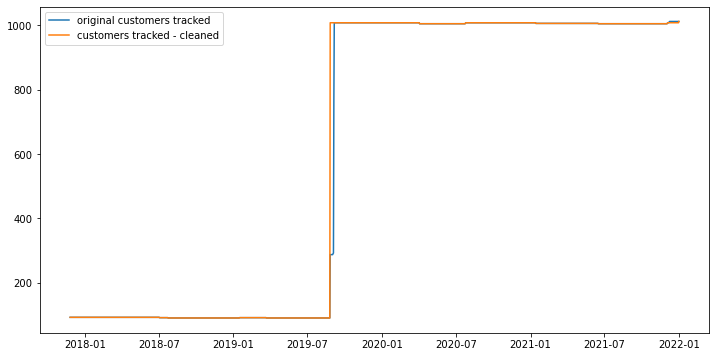

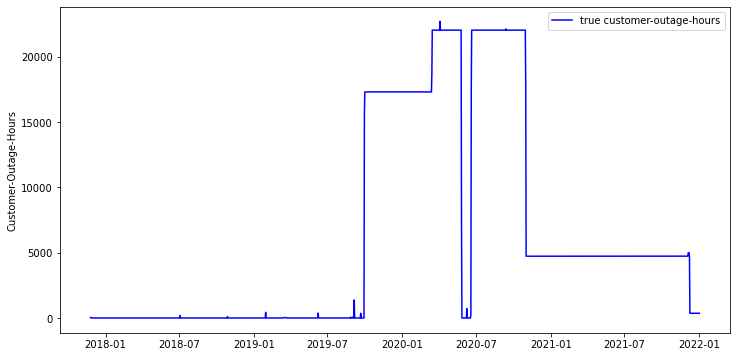

In [49]:
fips = "27107"

dc3 = dc[(dc.CountyFIPS == fips)]

fig, ax = plt.subplots(figsize=(12,6))
plt.plot(dc3.RecordDate, dc3.CustomersTracked, label="original customers tracked")
plt.plot(dc3.RecordDate, dc3.CustomersTracked_clean, label="customers tracked - cleaned")
plt.legend()

fig, ax = plt.subplots(figsize=(12,6))
plt.plot(dc3.RecordDate, dc3.CustomerHoursOutTotal, c="blue", label="true customer-outage-hours")
plt.legend()
plt.ylabel("Customer-Outage-Hours")


# Averaging Method (OG)

Country-level

In [50]:
def q75(x):
    return x.quantile(0.75)

ct = dc.groupby(["RecordDate","year"])[["CustomersTracked_clean","CustomerHoursOutTotal"]].sum().reset_index()

ct = ct.groupby(["year"]).agg({"CustomerHoursOutTotal":"sum", "CustomersTracked_clean":q75}).reset_index()

ct.columns = ["year","CustomerHoursOutTotal", "CustomersTracked_clean"]

ct.loc[:,"saidi"] = ct["CustomerHoursOutTotal"].div(ct["CustomersTracked_clean"])

ct

,year,CustomerHoursOutTotal,CustomersTracked_clean,saidi
0,2017,9.740488e+08,73755631.0,13.206433
1,2018,9.862781e+08,105173330.0,9.377645
2,2019,9.747452e+08,112775046.0,8.643270
3,2020,1.536394e+09,124121137.0,12.378179
4,2021,1.535823e+09,130807669.0,11.741076
5,2022,3.395986e+06,132446627.0,0.025640


County-level (summation method)

In [40]:
def q75(x):
    return x.quantile(0.75)

dm = dc.groupby(["StateName","CountyFIPS","CountyName","year"]).agg({"CustomersTracked_clean":q75,"CustomersTracked":q75,"CustomerHoursOutTotal":"sum"}).reset_index()

dm.columns = ["StateName","CountyFIPS","CountyName","year","CustomersTracked_clean","CustomersTracked","CustomerHoursOutTotal"]

dm["saidi_clean"] = dm["CustomerHoursOutTotal"].div(dm["CustomersTracked_clean"])
dm["saidi"] = dm["CustomerHoursOutTotal"].div(dm["CustomersTracked"])

dm

,StateName,CountyFIPS,CountyName,year,CustomersTracked_clean,CustomersTracked,CustomerHoursOutTotal,saidi_clean,saidi
0,alabama,01001,autauga,2017,16972.00,16972.00,63914.31,3.765868,3.765868
1,alabama,01001,autauga,2018,19485.00,19485.00,139187.74,7.143328,7.143328
2,alabama,01001,autauga,2019,19573.00,19573.00,89705.51,4.583125,4.583125
3,alabama,01001,autauga,2020,30465.75,30465.75,816984.59,26.816494,26.816494
4,alabama,01001,autauga,2021,28603.00,28603.00,326479.03,11.414153,11.414153
...,...,...,...,...,...,...,...,...,...
17346,wyoming,56043,washakie,2022,2702.00,2702.00,0.00,0.000000,0.000000
17347,wyoming,56045,weston,2019,43.00,43.00,21.54,0.500930,0.500930
17348,wyoming,56045,weston,2020,90.00,90.00,1027.06,11.411778,11.411778
17349,wyoming,56045,weston,2021,3937.00,3937.00,2966.46,0.753482,0.753482


CDF -- % county-year pairs by CustomersTracked

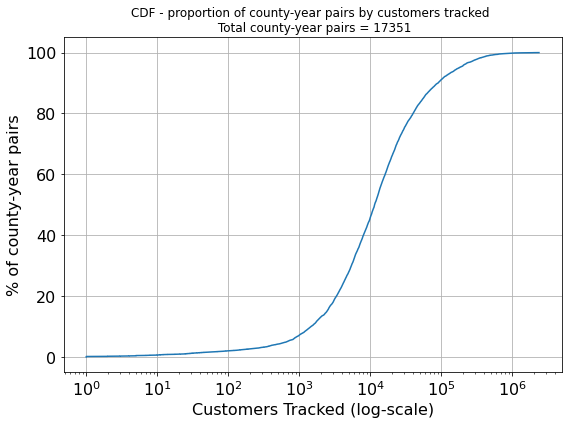

In [42]:
ct_cdf = dm[["CountyFIPS","year","CustomersTracked_clean"]].drop_duplicates().sort_values(by="CustomersTracked_clean").reset_index(drop=True)

ct_cdf["county-year_pairs"] = ct_cdf.index

ct_cdf["county-year_pairs"] = ct_cdf["county-year_pairs"]*100/ct_cdf["county-year_pairs"].max()


fig, ax = plt.subplots(figsize=(8,6))
fs = 16

plt.plot(ct_cdf["CustomersTracked_clean"], ct_cdf["county-year_pairs"])
plt.xlabel("Customers Tracked (log-scale)", fontsize=fs)
plt.ylabel("% of county-year pairs", fontsize=fs)
plt.title("CDF - proportion of county-year pairs by customers tracked \n Total county-year pairs = {}".format(len(ct_cdf)))
plt.xscale("log")
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.grid()

plt.tight_layout()

plt.savefig("./output/CDF_CustomersTracked.png", bbox_inches="tight")

plt.show()

CDF -- % county-year pairs by SAIDI

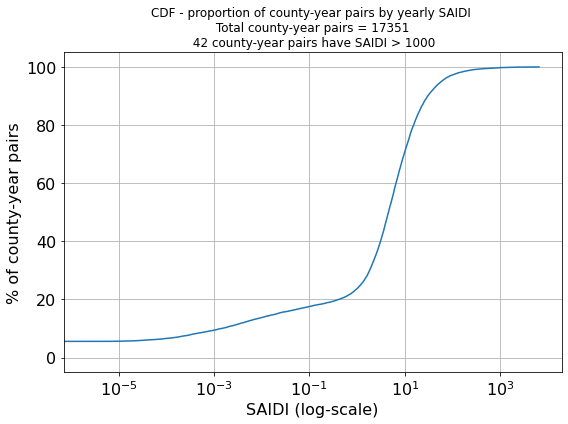

In [55]:
saidi_cdf = dm[["CountyFIPS","year","saidi_clean"]].drop_duplicates().sort_values(by="saidi_clean").reset_index(drop=True)

saidi_cdf["county-year_pairs"] = saidi_cdf.index

saidi_cdf["county-year_pairs"] = saidi_cdf["county-year_pairs"]*100/saidi_cdf["county-year_pairs"].max()


fig, ax = plt.subplots(figsize=(8,6))
fs = 16

plt.plot(saidi_cdf["saidi_clean"], saidi_cdf["county-year_pairs"])
plt.xlabel("SAIDI (log-scale)", fontsize=fs)
plt.ylabel("% of county-year pairs", fontsize=fs)
plt.title("CDF - proportion of county-year pairs by yearly SAIDI \n Total county-year pairs = {} \n {} county-year pairs have SAIDI > 1000".format(len(saidi_cdf), len(saidi_cdf[saidi_cdf["saidi_clean"]>1000])))
plt.xscale("log")

plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)

plt.grid()

plt.tight_layout()

plt.savefig("./output/CDF_yearlySAIDI.png", bbox_inches="tight")

plt.show()

'/home/zshah_umass_edu/projects/Poweroutages-inequity/poweroutages-inequity/scripts'

# Summation Method

County-level (summation method)

In [3]:
da = dc.copy()

da["month"] = da["RecordDate"].dt.month

da["saidi_clean"] = da["CustomerHoursOutTotal"]/da["CustomersTracked_clean"]
da["saidi"] = da["CustomerHoursOutTotal"]/da["CustomersTracked"]

da_year = da.groupby(["StateName","CountyFIPS","CountyName","year"])[["saidi_clean","saidi"]].sum().reset_index()
da_month = da.groupby(["StateName","CountyFIPS","CountyName","year","month"])[["saidi_clean","saidi"]].sum().reset_index()

In [5]:
len(da_year[(da_year.saidi_clean >= 1000)].sort_values(by="saidi_clean"))

55

Country-level (summation method)

In [ ]:
dg = dc.copy()

dg = dg.groupby(["RecordDate","year"])[["CustomerHoursOutTotal","CustomersTracked_clean","CustomersTracked"]].sum().reset_index()

dg["saidi_clean"] = dg["CustomerHoursOutTotal"]/dg["CustomersTracked_clean"]
dg["saidi"] = dg["CustomerHoursOutTotal"]/dg["CustomersTracked"]

dg_year = dg.groupby(["year"])[["saidi_clean","saidi"]].sum().reset_index() 

In [ ]:
dg_year